In [1]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
target = pd.read_csv('data/SampleSubmissionStage1.csv').set_index('ID').drop('Pred', axis=1)
target['Season'] = target.index.map(lambda i: i[:4])
target['team_a'] = target.index.map(lambda i: i[5:9])
target['team_b'] = target.index.map(lambda i: i[10:14])
target['in_target'] = True
target.sample()

,Season,team_a,team_b,in_target
ID,,,,
2016_1428_1462,2016,1428,1462,True


In [3]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
ncaa_games['is_ncaa_game'] = True
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 10)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff,is_ncaa_game
261,1989,136,1278,86,1243,75,N,0,11,True


In [4]:
regular_games = pd.read_csv('data/RegularSeasonCompactResults.csv')
regular_games = regular_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
regular_games['diff'] = regular_games['WScore'] - regular_games['LScore']
regular_games['is_ncaa_game'] = False
print(regular_games.shape)
regular_games.sample()

(150684, 10)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff,is_ncaa_game
28548,1992,47,1424,79,1185,59,N,0,20,False


In [5]:
rankings_teams = pd.read_csv('data/MasseyOrdinals.csv')
rankings_teams = rankings_teams.astype({
    'TeamID' : str,
    'Season' : str
})
print(rankings_teams.shape)
rankings_teams.sample()

(3200201, 5)


,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
158335,2004,63,MGY,1155,93


In [15]:
data = pd.concat([ncaa_games, regular_games])
# data = cp.deepcopy(ncaa_games)
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win']]
data = pd.concat([data, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})

lags = 1
for team, opponent_team in [('a', 'b'), ('b','a')]:
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_season = regular_games\
        .groupby(['Season', 'WTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_season_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_season[
            'won_in_season_{}_lag-{}'.format(team, l)] = won_in_season[
            'won_in_season_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_season.drop('won_in_season_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_season,
                    left_on=['Season', 'team_{}'.format(team)], 
                    right_index=True,
                    how='left')
    
    
    # SEASON WINS AGAINST THE OPPONENT
    season_wins_against_opponent = regular_games.groupby(['Season', 'WTeamID', 'LTeamID']).sum()[['diff']]\
        .rename(columns={'diff': 'season_wins_against_opponent_{}'.format(team)}).fillna(0)
    for l in range(1, lags+1):
        season_wins_against_opponent['season_wins_against_opponent_{}_lag-{}'.format(team, l)] =\
            season_wins_against_opponent['season_wins_against_opponent_{}'.format(team)].shift(l)
    season_wins_against_opponent.drop('season_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, season_wins_against_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # AVERAGE DIFF TO OPPONENT IN THE SEASON
    average_win_diff = regular_games.groupby(['Season', 'WTeamID', 'LTeamID']).mean()[['diff']]\
        .rename(columns={'diff': 'average_win_diff_{}'.format(team)})
    for l in range(1, lags+1):
        average_win_diff[
            'average_win_diff_{}_lag-{}'.format(team, l)] = average_win_diff[
            'average_win_diff_{}'.format(team)
        ].shift(l).fillna(0)
    average_win_diff.drop('average_win_diff_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, average_win_diff,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_ncaa = ncaa_games\
        .groupby(['Season', 'WTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_ncaa_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_ncaa[
            'won_in_ncaa_{}_lag-{}'.format(team, l)] = won_in_ncaa[
            'won_in_ncaa_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_ncaa.drop('won_in_ncaa_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_ncaa,
                    left_on=['Season', 'team_{}'.format(team)], 
                    right_index=True,
                    how='left').fillna(0)

    
    # AVERAGE RANKING OF TEAMS IN PAST SEASONS
    average_rank_teams = rankings_teams\
        .groupby([ 'TeamID','Season',]).mean()[['OrdinalRank']]\
        .rename(columns={'OrdinalRank':'average_rank_team_{}'.format(team)})
    for l in range(1, lags+1):
        average_rank_teams[
            'average_rank_team_{}_lag-{}'.format(team, l)] = average_rank_teams[
            'average_rank_team_{}'.format(team)
        ].shift(l).fillna(0)
    average_rank_teams.drop('average_rank_team_{}'.format(team), inplace = True, axis = 1)
    data = pd.merge(data, average_rank_teams,
                    left_on=['team_{}'.format(team), 'Season'],
                    right_index = True,
                    how='left').fillna(0)
    
data = data.dropna()
print(data.shape)
data.head(5)

(161913, 15)


,Season,a_win,in_target,team_a,team_b,won_in_season_a_lag-1,season_wins_against_opponent_a_lag-1,average_win_diff_a_lag-1,won_in_ncaa_a_lag-1,average_rank_team_a_lag-1,won_in_season_b_lag-1,season_wins_against_opponent_b_lag-1,average_win_diff_b_lag-1,won_in_ncaa_b_lag-1,average_rank_team_b_lag-1
0,1985,True,False,1116,1234,17.0,0.0,0.0,2.0,0.0,25.0,29.0,29.0,0.0,0.0
1,1985,True,False,1120,1345,15.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
2,1985,True,False,1207,1250,17.0,0.0,0.0,1.0,0.0,19.0,0.0,0.0,0.0,0.0
3,1985,True,False,1229,1425,23.0,0.0,0.0,2.0,0.0,27.0,0.0,0.0,0.0,0.0
4,1985,True,False,1242,1325,12.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0,0.0,0.0


##### Problem with the variables created: When shifting (l) rows down, teams get the avg ranking from the previous team if it's their first years. TODO 

In [16]:
data.describe()

,won_in_season_a_lag-1,season_wins_against_opponent_a_lag-1,average_win_diff_a_lag-1,won_in_ncaa_a_lag-1,average_rank_team_a_lag-1,won_in_season_b_lag-1,season_wins_against_opponent_b_lag-1,average_win_diff_b_lag-1,won_in_ncaa_b_lag-1,average_rank_team_b_lag-1
count,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000
mean,14.226949,8.728329,6.987853,0.279681,85.961572,14.631592,9.010123,7.285630,0.268212,83.952434
std,6.143611,11.814573,9.096658,0.847990,107.336053,6.078525,11.857482,9.290112,0.805577,105.103301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,3.000000,3.000000,0.000000,19.642032,14.000000,4.000000,4.000000,0.000000,20.805936
75%,19.000000,14.000000,11.666667,0.000000,170.252427,19.000000,15.000000,12.000000,0.000000,162.436585
max,34.000000,129.000000,82.000000,6.000000,350.113356,34.000000,118.000000,91.000000,6.000000,350.113356


In [17]:
from LightGBM import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data[~data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y = data[~data.in_target.astype(bool)][['a_win']]

kf = KFold(n_splits=5, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    lgbm = LGBMClassifier(n_estimators=500,
                          learning_rate=0.01)
    lgbm.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = lgbm.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.187814048022
0.186616175706
0.18724803339
0.186001729719
0.187643301186
Metric Mean: 0.19 (0.00)


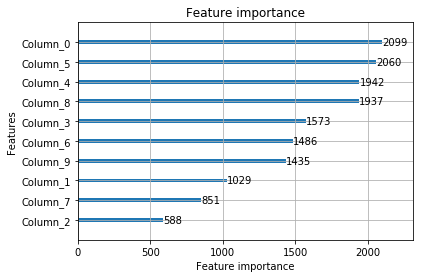

In [19]:
from LightGBM import plot_importance

plot_importance(lgbm, max_num_features=25)
plt.show()

In [20]:
pd.Series(X.columns)

0                   won_in_season_a_lag-1
1    season_wins_against_opponent_a_lag-1
2                average_win_diff_a_lag-1
3                     won_in_ncaa_a_lag-1
4               average_rank_team_a_lag-1
5                   won_in_season_b_lag-1
6    season_wins_against_opponent_b_lag-1
7                average_win_diff_b_lag-1
8                     won_in_ncaa_b_lag-1
9               average_rank_team_b_lag-1
dtype: object

In [21]:
X_sub = data[data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y_sub = data[data.in_target.astype(bool)][['Season', 'team_a', 'team_b', 'a_win', 'in_target']]

lgbm = LGBMClassifier()
lgbm.fit(X.values, y.values.reshape(-1))
preds = lgbm.predict_proba(X_sub.values)

sub = cp.deepcopy(y_sub)
sub['Pred'] = preds[:,1]
sub['ID'] = sub['Season'].map(str) + '_' + sub['team_a'].map(str) + '_' + sub['team_b'].map(str)
sub.set_index('ID', inplace=True)
sub.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1, inplace=True)
sub.head()

,Pred
ID,
2014_1107_1110,0.999438
2014_1107_1112,0.144811
2014_1107_1113,0.999212
2014_1107_1124,0.101373
2014_1107_1140,0.999342


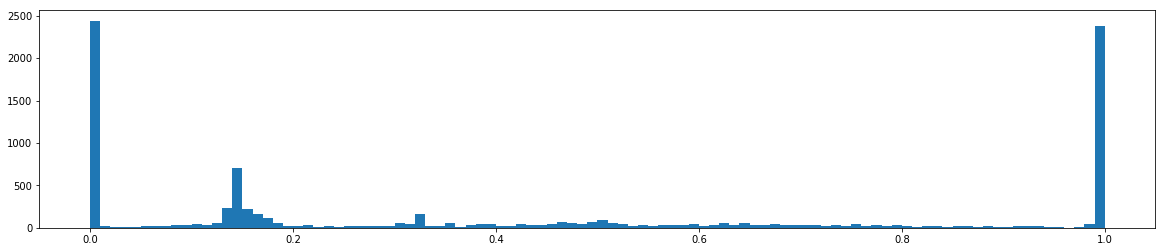

In [22]:
plt.figure(figsize=(20,4))
plt.hist(sub['Pred'], bins=100)
plt.show()

In [23]:
sub.to_csv('submissions/lgbm_baseline_1.csv')

In [24]:
lgbm = pd.read_csv('submissions/lgbm_baseline_1.csv')
three = pd.read_csv('submissions/xgb_baseline_3.csv')

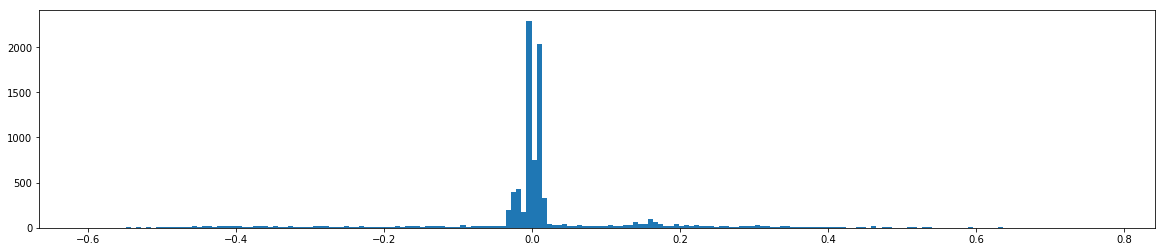

In [25]:
plt.figure(figsize=(20,4))
plt.hist(lgbm['Pred'] - three['Pred'], bins=200)
plt.show()